# Load the Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from matplotlib.colors import ListedColormap
%matplotlib inline
warnings.filterwarnings('ignore')

# for plotting
cmap2 = ListedColormap(['r', 'k'])
cmap4 = ListedColormap(['k', 'r', 'g', 'b'])
plt.rc("font",family="sans-serif",size=20)
plt.rcParams["font.sans-serif"] = "Arial"

#hold data
mice = list()
synthetic = list()

### Synthetic Dataset

* There are 4 clusters in the target dataset (but we do not know their labels *a priori*. 
* In the background, all the data pts are from the same distribution, which has different variances in three subspaces.

In [2]:
from scipy.stats import ortho_group
np.random.seed(0) # for reproducibility

# In A there are four clusters.
N = 400; D = 30; gap=1.5
rotation = ortho_group.rvs(dim=D)

target_ = np.zeros((N, D))
target_[:,0:10] = np.random.normal(0,10,(N,10))
# group 1
target_[0:100, 10:20] = np.random.normal(-gap,1,(100,10))
target_[0:100, 20:30] = np.random.normal(-gap,1,(100,10))
# group 2
target_[100:200, 10:20] = np.random.normal(-gap,1,(100,10))
target_[100:200, 20:30] = np.random.normal(gap,1,(100,10))
# group 3
target_[200:300, 10:20] = np.random.normal(2*gap,1,(100,10))
target_[200:300, 20:30] = np.random.normal(-gap,1,(100,10))
# group 4
target_[300:400, 10:20] = np.random.normal(2*gap,1,(100,10))
target_[300:400, 20:30] = np.random.normal(gap,1,(100,10))
target_ = target_.dot(rotation)
sub_group_labels_ = [0]*100+[1]*100+[2]*100+[3]*100

background_ = np.zeros((N, D))
background_[:,0:10] = np.random.normal(0,10,(N,10))
background_[:,10:20] = np.random.normal(0,3,(N,10))
background_[:,20:30] = np.random.normal(0,1,(N,10))
background_ = background_.dot(rotation)

data_ = np.concatenate((background_, target_))
labels_ = len(background_)*[0] + len(target_)*[1]

### Mice Protein Dataset

In [3]:
data = np.genfromtxt('datasets/Data_Cortex_Nuclear.csv',delimiter=',',
                     skip_header=1,usecols=range(1,78),filling_values=0)
classes = np.genfromtxt('datasets/Data_Cortex_Nuclear.csv',delimiter=',',
                        skip_header=1,usecols=range(78,81),dtype=None)

* Target consists of mice that have been stimulated by shock therapy. Some have Down Syndrome, others don't, but we assume this label is not known to us *a priori*
* Background consists of mice that have not been stimulated by shock therapy, and do not have Down Syndrome

In [4]:
target_idx_A = np.where((classes[:,-1]==b'S/C') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Control'))[0]
target_idx_B = np.where((classes[:,-1]==b'S/C') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Ts65Dn'))[0]

sub_group_labels = len(target_idx_A)*[0] + len(target_idx_B)*[1]
target_idx = np.concatenate((target_idx_A,target_idx_B))                                                                          

target = data[target_idx]
target = (target-np.mean(target,axis=0)) / np.std(target,axis=0) # standardize the dataset

background_idx = np.where((classes[:,-1]==b'C/S') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Control'))
# background_idx = np.where((classes[:,-1]==b'C/S') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Ts65Dn'))
background = data[background_idx]
background = (background-np.mean(background,axis=0)) / np.std(background,axis=0) # standardize the dataset
labels = len(background)*[0] + len(target)*[1]
data = np.concatenate((background, target))

# Comparing cPCA to Other Dimensionality Reduction Techniques

### PCA and cPCA

(PCA corresponds to the first column, since it is equivalent to cPCA with $\alpha=0$)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


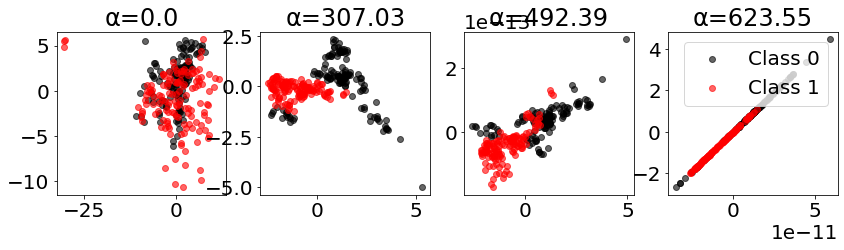

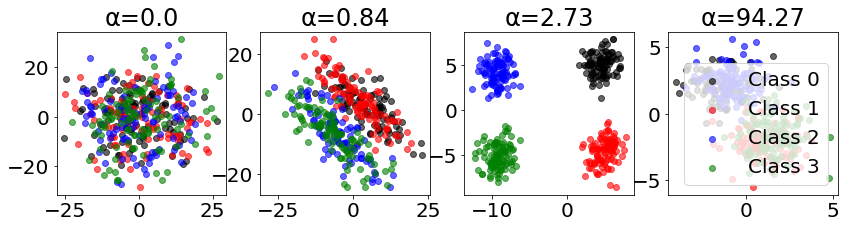

In [5]:
from contrastive import CPCA
mdl = CPCA()
projected_data = mdl.fit_transform(target, background, sub_group_labels)
mdl.plot(target, sub_group_labels)

mdl_ = CPCA()
projected_data_ = mdl_.fit_transform(target_, background_, sub_group_labels_)
mdl_.plot(target_, sub_group_labels_)

mice.append(projected_data[1])
mice.append(projected_data[0])

synthetic.append(projected_data_[2])
synthetic.append(projected_data_[0])

* PCA is unable to resolve the subgroups of interest in the mice data,  while cPCA is able to separate the 2 subgroups with an appropriate (and automatically discovered) value of $\alpha$
* PCA is unable to resolve the subgroups in the synthetic data, while cPCA is able to resolve all 4 with an appropriate (and automatically discovered) value of $\alpha$ (2.15). An alternative value of $\alpha$ (151.18) discovers another interesting projection.

### Supervised PCA

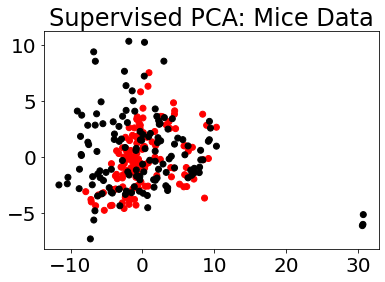

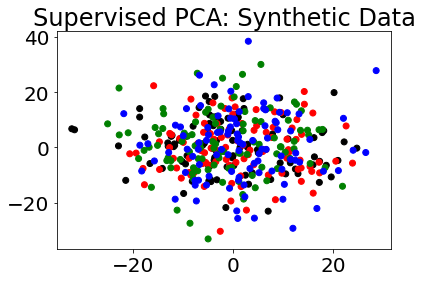

In [6]:
from supervised import SupervisedPCAClassifier

mdl = SupervisedPCAClassifier(n_components=2)

projected_data = mdl.fit(data, labels).get_transformed_data(target)
plt.figure()
plt.scatter(*projected_data.T, c=sub_group_labels, cmap=cmap2)
plt.title('Supervised PCA: Mice Data')

projected_data_ = mdl.fit(data_, labels_).get_transformed_data(target_)
plt.figure()
plt.scatter(*projected_data_.T, c=sub_group_labels_, cmap=cmap4)
plt.title('Supervised PCA: Synthetic Data')

mice.append(projected_data)
synthetic.append(projected_data_)

* Supervised PCA is unable to resolve the subgroups of interest in the mice data
* Supervised PCA is unable to resolve the subgroups in the synthetic data

### Linear Discriminant Analysis (LDA)

Note: because LDA returns at most $c-1$ components, where $c$ is the number of classes in the data, in this case, the target data is projected onto exactly 1 dimension (the x-dimension). For ease of visualization, we assign a random value to the y-dimension of each data point, and plot them in 2 dimensions.

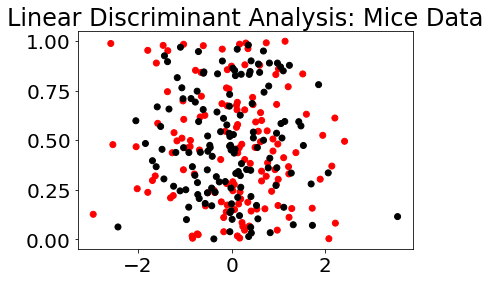

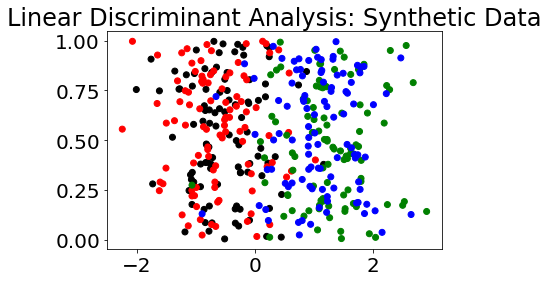

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
mdl = LDA()

projected_data = mdl.fit(data, labels).transform(target)
random_y_values = np.random.random(size=projected_data.shape)
plt.figure()
plt.scatter(projected_data, random_y_values, c=sub_group_labels, cmap=cmap2)
plt.title('Linear Discriminant Analysis: Mice Data')

mice.append(np.array([projected_data,random_y_values]).T)

projected_data_ = mdl.fit(data_, labels_).transform(target_)
random_y_values_ = np.random.random(size=projected_data_.shape)
plt.figure()
plt.scatter(projected_data_, random_y_values_, c=sub_group_labels_, cmap=cmap4)
plt.title('Linear Discriminant Analysis: Synthetic Data')

synthetic.append(np.array([projected_data_,random_y_values_]).T)

* LDA is unable to resolve the subgroups of interest in the mice data
* LDA is able to somewhat resolve two pairs of subgroups in the synthetic data, but not all four

### Quadratic Discriminant Analysis (QDA)

Note: Unlike the PCA or LDA, the QDA does not return a subspace on which to project the data for dimensionality reduction. Instead, we plotted each point based according to its posterior class probability.

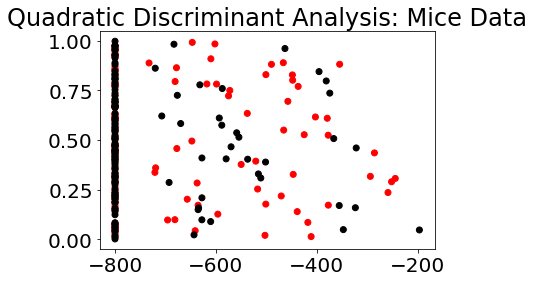

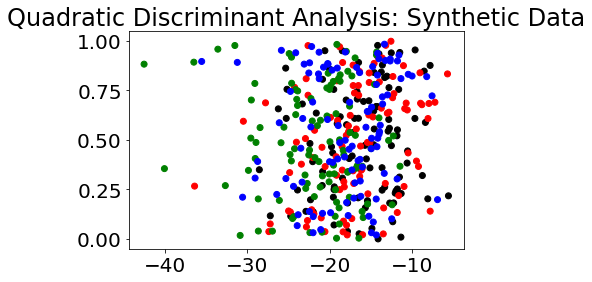

In [8]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from numpy import inf
mdl = QDA()

projected_data = mdl.fit(data, labels).predict_log_proba(target)[:,0]
projected_data[projected_data == -inf] = -800
random_y_values = np.random.random(size=projected_data.shape)
plt.figure()
# print(projected_data.shape,random_y_values.shape)
plt.scatter(projected_data, random_y_values, c=sub_group_labels, cmap=cmap2)
plt.title('Quadratic Discriminant Analysis: Mice Data')

mice.append(np.array([projected_data,random_y_values]).T)

projected_data_ = mdl.fit(data_, labels_).predict_log_proba(target_)[:,0]
random_y_values_ = np.random.random(size=projected_data_.shape)
plt.figure()
plt.scatter(projected_data_, random_y_values_, c=sub_group_labels_, cmap=cmap4)
plt.title('Quadratic Discriminant Analysis: Synthetic Data')

synthetic.append(np.array([projected_data_,random_y_values_]).T)

* QDA is unable to resolve the subgroups of interest in the mice data
* QDA is unable to resolve the subgroups in the synthetic data

### Linear Regression + PCA

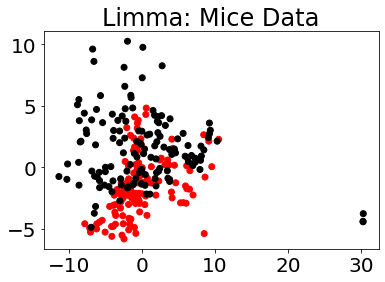

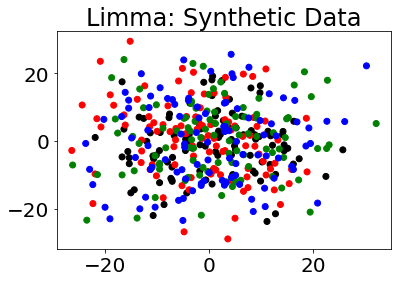

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

lr = LinearRegression()
lr.fit(data, labels)
idx = np.where(np.abs(lr.coef_)>0.0001)[0] # get significant directions
target_reduced = target[:,idx]
mdl = PCA(n_components=2)
projected_data = mdl.fit_transform(target_reduced)
plt.figure()
plt.scatter(*projected_data.T, c=sub_group_labels, cmap=cmap2)
plt.title('Limma: Mice Data')

mice.append(projected_data)

lr = LinearRegression()
lr.fit(data_, labels_)
idx = np.where(np.abs(lr.coef_)>0.0001)[0] # get significant directions
target_reduced_ = target_[:,idx]
mdl = PCA(n_components=2)
projected_data_ = mdl.fit_transform(target_reduced_)
plt.figure()
plt.scatter(*projected_data_.T, c=sub_group_labels_, cmap=cmap4)
plt.title('Limma: Synthetic Data')

synthetic.append(projected_data_)

### Multidimensional Scaling (MDS)

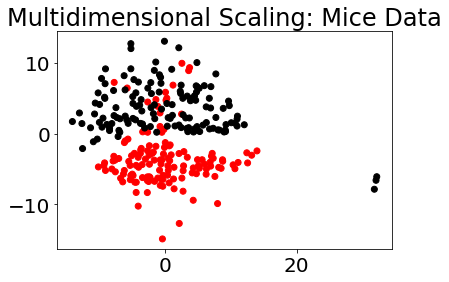

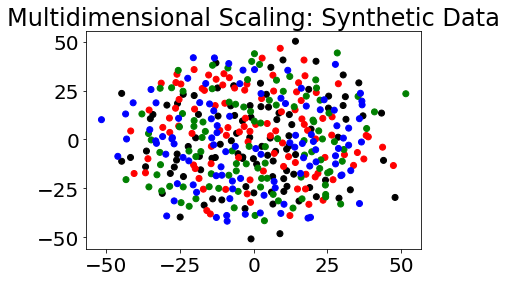

In [10]:
from sklearn.manifold import MDS
np.random.seed(0) # for reproducibility

mdl = MDS(n_components=2)
projected_data = mdl.fit_transform(target)
plt.figure()
plt.scatter(*projected_data.T, c=sub_group_labels, cmap=cmap2)
plt.title('Multidimensional Scaling: Mice Data')

projected_data_ = mdl.fit_transform(target_)
plt.figure()
plt.scatter(*projected_data_.T, c=sub_group_labels_, cmap=cmap4)
plt.title('Multidimensional Scaling: Synthetic Data')

mice.append(projected_data)
synthetic.append(projected_data_)

* MDS is mostly able to resolve the subgroups of interest in the mice data, although not as well as cPCA (if the same plot had been plotted without the subgroups colored differently, it would be harder to resolve the subgroups)
* MDS is unable to resolve the subgroups in the synthetic data

### Principal Component Pursuit

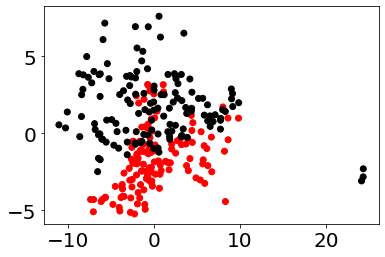

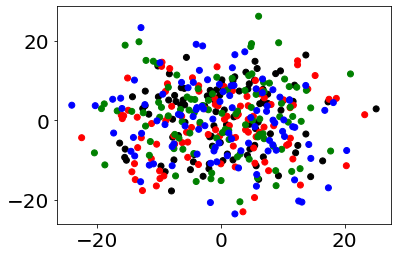

In [11]:
from pursuit import R_pca
from sklearn.decomposition import PCA

mdl = PCA(n_components=2) # this will be used to select the top 2 principal pursuit components

rpca = R_pca(target)
L, S = rpca.fit(max_iter=10000) #L is the low-rank structure we are interested in 
projected_data = mdl.fit_transform(L)
plt.figure()
plt.scatter(*projected_data.T, c=sub_group_labels, cmap=cmap2)

rpca_ = R_pca(target_)
L_, S_ = rpca_.fit(max_iter=10000) #L is the low-rank structure we are interested in 
projected_data_ = mdl.fit_transform(L_)
plt.figure()
plt.scatter(*projected_data_.T, c=sub_group_labels_, cmap=cmap4)

mice.append(projected_data)
synthetic.append(projected_data_)

* PCP is unable to resolve the subgroups of interest in the mice data (again, consider if the subgroups had not been color-coded), although it does a better job than PCA
* PCP is unable to resolve the subgroups in the synthetic data perfectly

### Factor Analysis

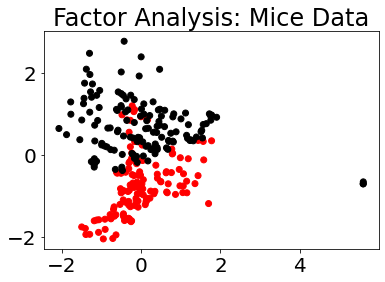

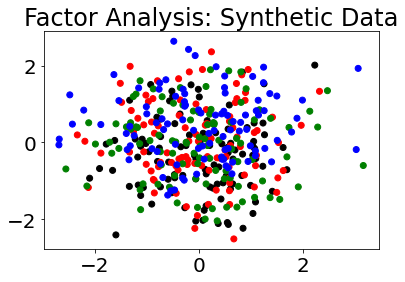

In [12]:
from sklearn.decomposition import FactorAnalysis as FA

mdl = FA(n_components=2)

projected_data = mdl.fit_transform(target)
plt.figure()
plt.scatter(*projected_data.T, c=sub_group_labels, cmap=cmap2)
plt.title('Factor Analysis: Mice Data')

projected_data_ = mdl.fit_transform(target_)
plt.figure()
plt.scatter(*projected_data_.T, c=sub_group_labels_, cmap=cmap4)
plt.title('Factor Analysis: Synthetic Data')

mice.append(projected_data)
synthetic.append(projected_data_)

* FA is unable to resolve the subgroups of interest in the mice data (again, consider if the subgroups had not been color-coded), although it does a better job than PCA
* FA is unable to resolve the subgroups in the synthetic data perfectly

### Independent Component Analysis

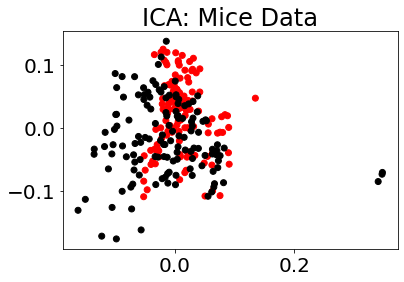

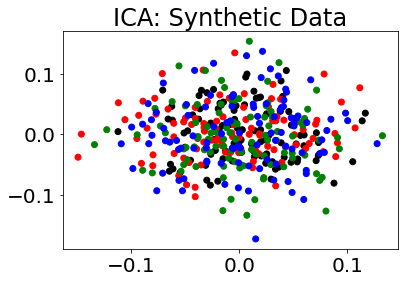

In [13]:
from sklearn.decomposition import FastICA as ICA

mdl = ICA(n_components=2)

projected_data = mdl.fit_transform(target)
plt.figure()
plt.scatter(*projected_data.T, c=sub_group_labels, cmap=cmap2)
plt.title('ICA: Mice Data')

projected_data_ = mdl.fit_transform(target_)
plt.figure()
plt.scatter(*projected_data_.T, c=sub_group_labels_, cmap=cmap4)
plt.title('ICA: Synthetic Data')

mice.append(projected_data)
synthetic.append(projected_data_)

* ICA is unable to resolve the subgroups of interest in the mice data
* ICA is unable to resolve the subgroups in the synthetic datam

# Comprehensive Plots

ValueError: 'c' argument has 270 elements, which is inconsistent with 'x' and 'y' with size 1.

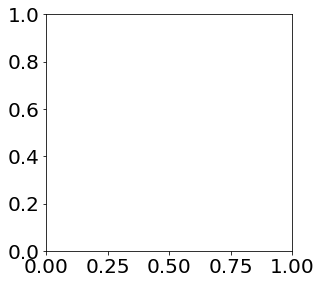

In [14]:
method_names = ['cPCA','PCA','Supervised PCA','LDA','QDA','LR+PCA','MDS','PC Pursuit','FA','ICA']
plt.figure(figsize=[15, 20])

k = len(mice)
for i in range(k):
    #ax = plt.subplot((k+1)/2,2,i+1)
    ax = plt.subplot(4,3,i+1+2*(i>0)+(i==0))
    plt.scatter(*mice[i].T, c=sub_group_labels, cmap=cmap2, alpha=0.6)
    plt.title(method_names[i])
plt.tight_layout()
plt.savefig('mice10.jpg')

In [ ]:
method_names = ['cPCA','PCA','Supervised PCA','LDA','QDA','LR+PCA','MDS','PC Pursuit','FA','ICA']
plt.figure(figsize=[15, 20])

k = len(mice)
for i in range(k):
    #ax = plt.subplot((k+1)/2,2,i+1)
    ax = plt.subplot(4,3,i+1+2*(i>0)+(i==0))
    plt.scatter(*synthetic[i].T, c=sub_group_labels_, cmap=cmap4, alpha=0.6)
    plt.title(method_names[i])
plt.tight_layout()
plt.savefig('synthetic10.jpg')